In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Analyzing largest, second largest and average cluster size as a function of kT and secondary bond weight

In [9]:
data_path = '/Users/stephenthomas/Google Drive/Research/2017/LabNotes/Data/Jun1/bondweight_study_outside_exponent/data'

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


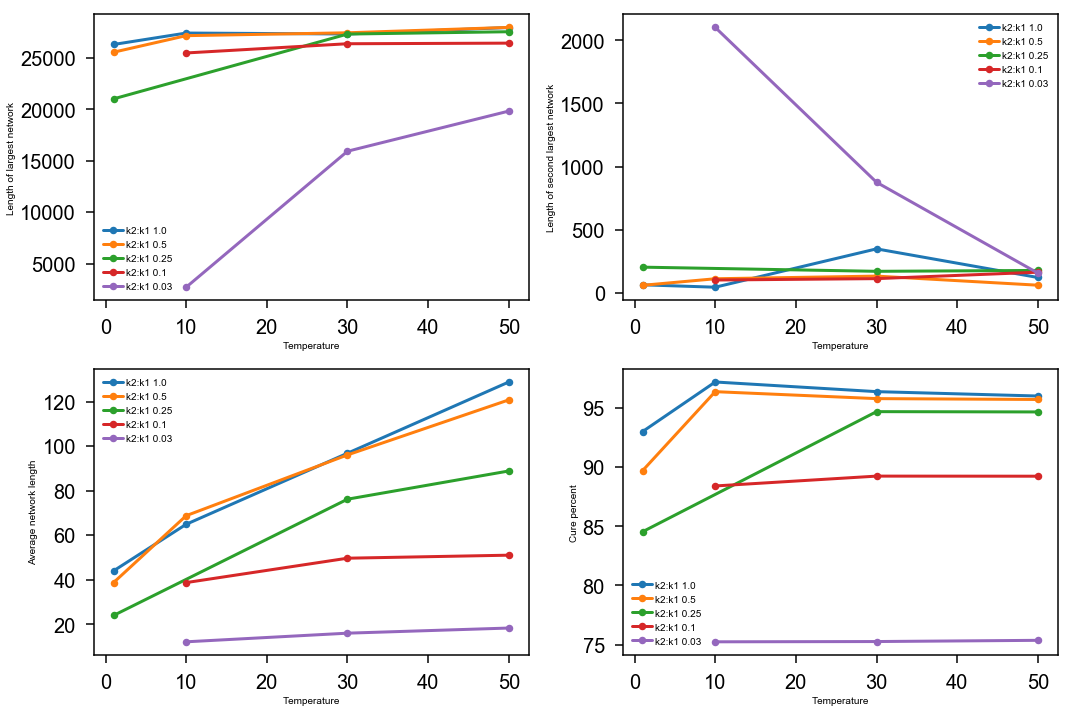

In [38]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', data_path)


sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
#fig, ax1 = plt.subplots(figsize=(15,10))
kTs=[1,10,30,50]
    
for sbw in sbws:
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []
    cure_percent = []
    plt_kTs = []    
    for kT in kTs:
        jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
        for job in jobs:
            #print(job)
            job_status = get_status(job)
            #print(job.sp.temp_prof[-1][1])
            if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae' and job.sp.temp_prof[-1][1] ==kT:
                #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
                #print(job)
                plt_kTs.append(job.sp.temp_prof[-1][1])
                f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
                t = gsd.hoomd.HOOMDTrajectory(f)
                n_frames = len(t)
                #print('total frames ',n_frames)
                connected_components = []
                last_frame = n_frames-1
                snapshot = t[last_frame]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                G.graph
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                n_connected = nx.number_connected_components(G)
                largest_cc = max(nx.connected_components(G), key=len)
                connected_components.append(n_connected)
                largest_networks.append(len(largest_cc))
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
                second_largest_networks.append(sorted_cc[1])
                average_network_lens.append(np.mean(sorted_cc))

                curing_data = np.genfromtxt(job.fn('curing.log'))
                cure_percent.append(curing_data[-1,1])
    ax1.plot(plt_kTs, largest_networks,linestyle='-',marker='o',label='k2:k1 {}'.format(round(1/sbw,2)))
    ax2.plot(plt_kTs, second_largest_networks,linestyle='-',marker='o',label='k2:k1 {}'.format(round(1/sbw,2)))
    ax3.plot(plt_kTs, average_network_lens,linestyle='-',marker='o',label='k2:k1 {}'.format(round(1/sbw,2)))
    ax4.plot(plt_kTs, cure_percent,linestyle='-',marker='o',label='k2:k1 {}'.format(round(1/sbw,2)))
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Length of largest network')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Length of second largest network')
ax3.set_xlabel('Temperature')
ax3.set_ylabel('Average network length')
ax4.set_xlabel('Temperature')
ax4.set_ylabel('Cure percent')
fig.tight_layout()
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.show()

### Analyzing distribution of cluster size as a function of time

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


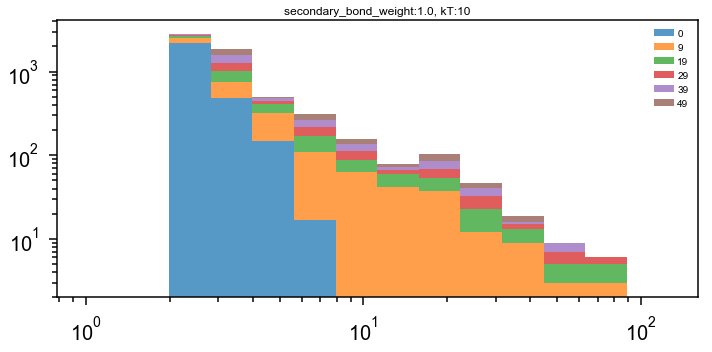

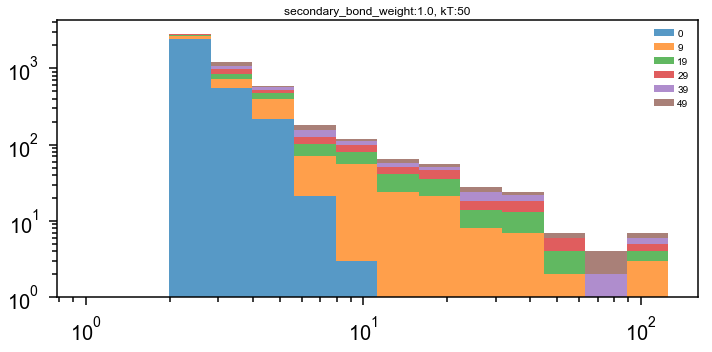

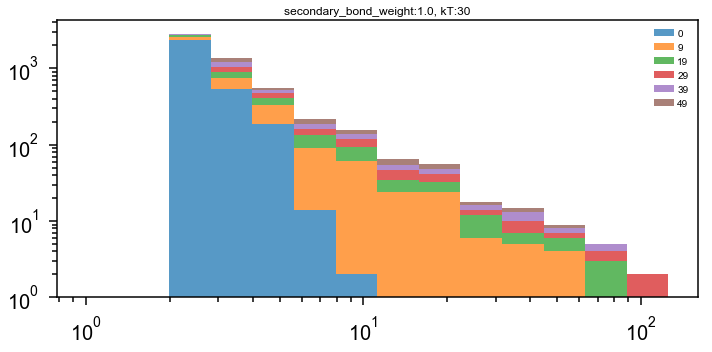

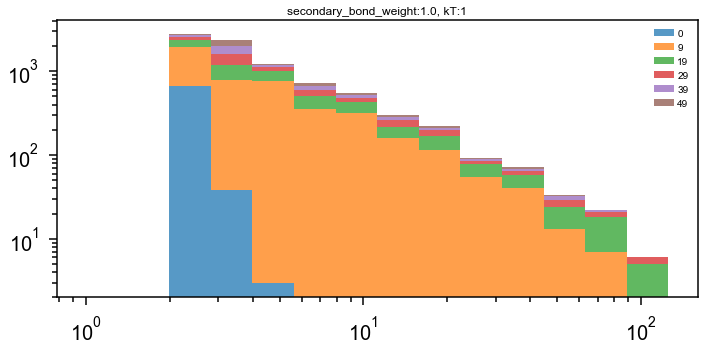

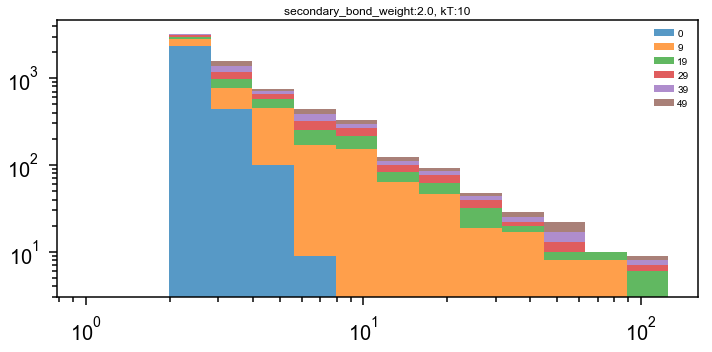

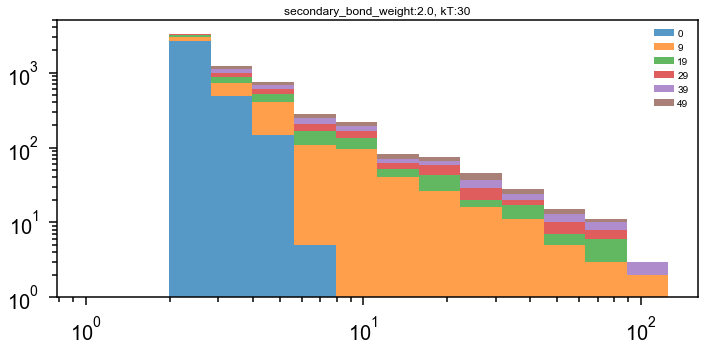

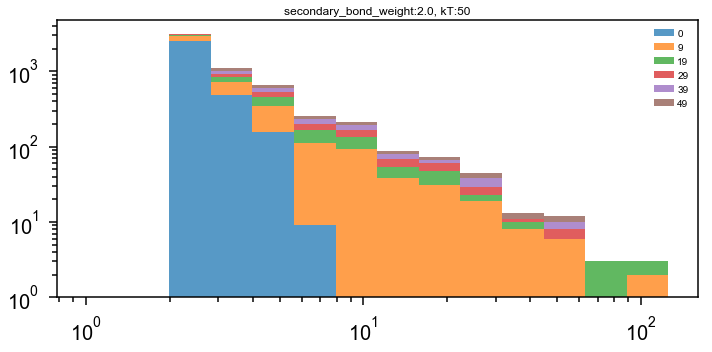

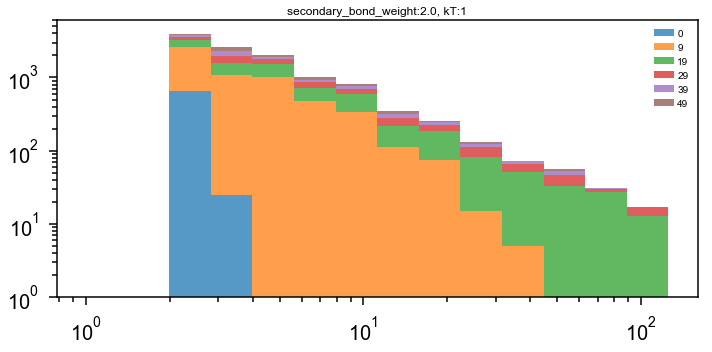

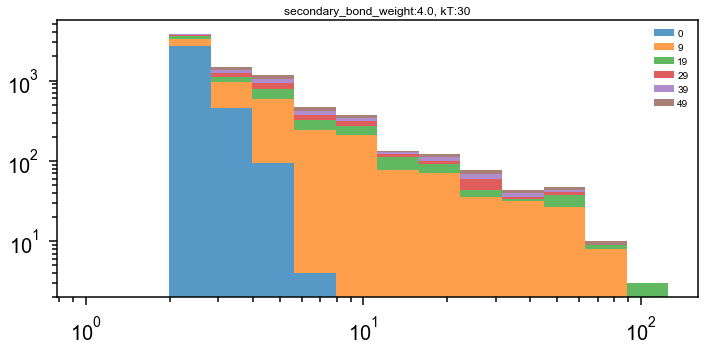

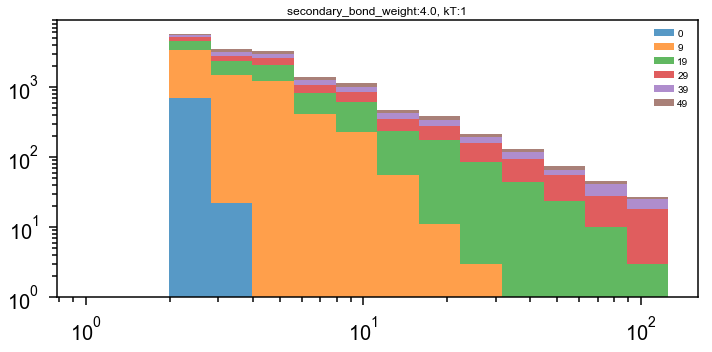

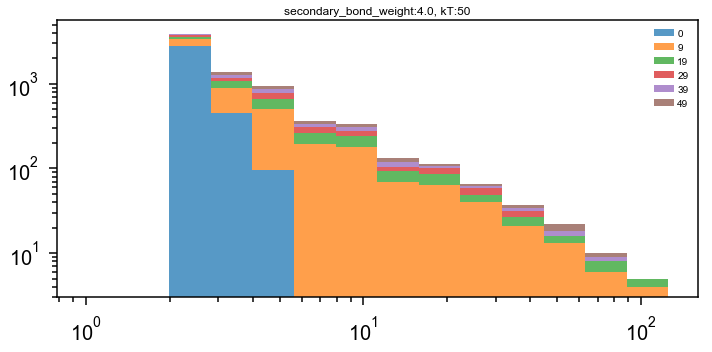

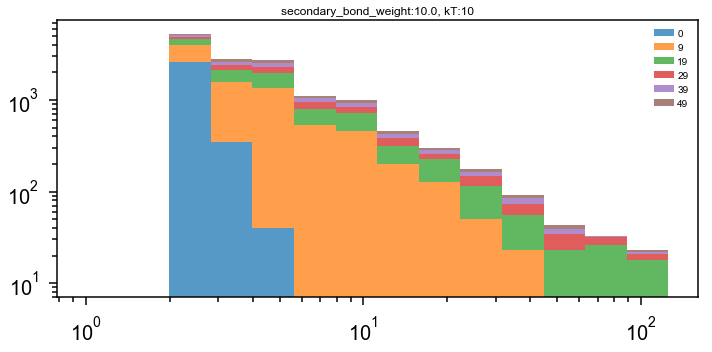

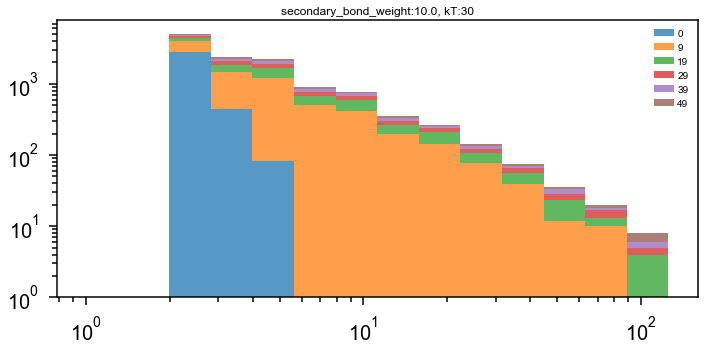

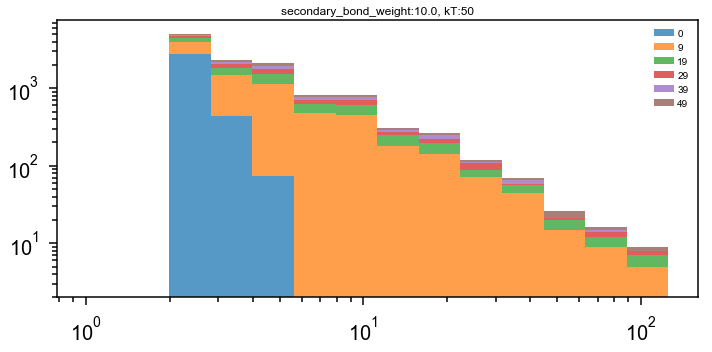

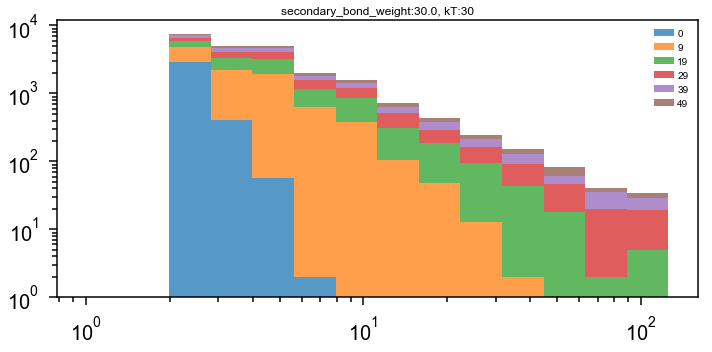

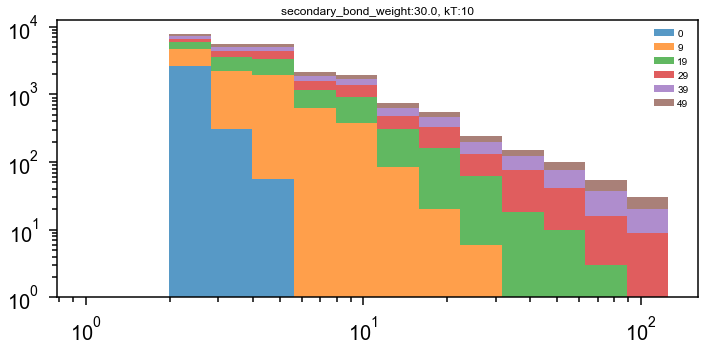

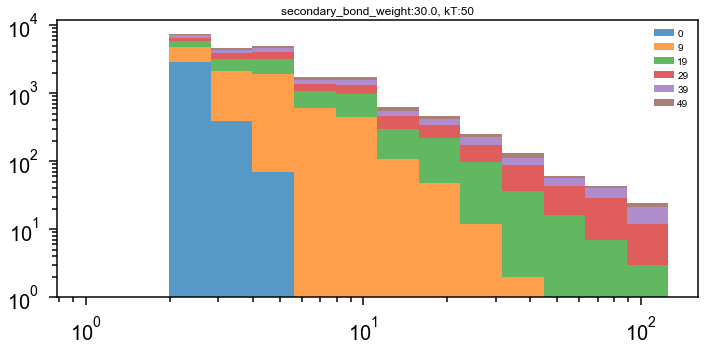

In [61]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
plt.figure(figsize=(15,10))

for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=False)]
                cluster_distributions.append(sorted_cc)
                
            bins = np.logspace(0,2.1,num=15)
            #print(bins)
            plt.figure(figsize=(10,5))
            n, bins, patches = plt.hist(cluster_distributions, bins=bins, alpha=0.75,log=True,stacked=True,
                                        histtype='barstacked',label=time_steps)
            plt.legend()
            plt.xlabel('Molecular weight')
            plt.ylabel('Occurences')
            
            plt.xscale('log')
            plt.yscale('log')
            plt.title('k2:k1{}, kT:{}'.format(round(1/sbw,3),kT))
            plt.savefig('sbw_{}_kT_{}.png'.format(round(1/sbw,3),kT))
            plt.show()

/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


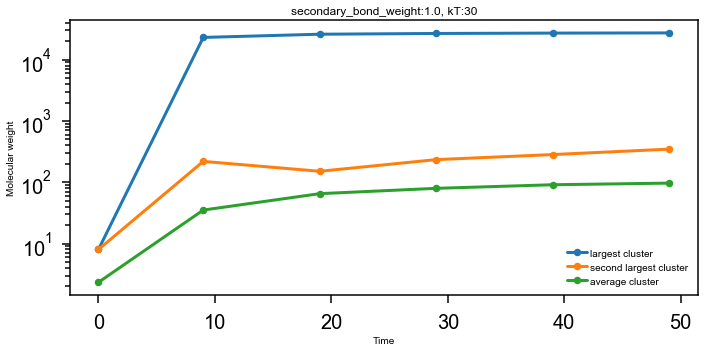

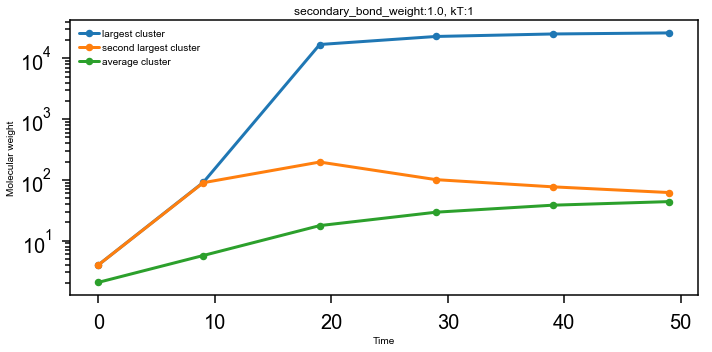

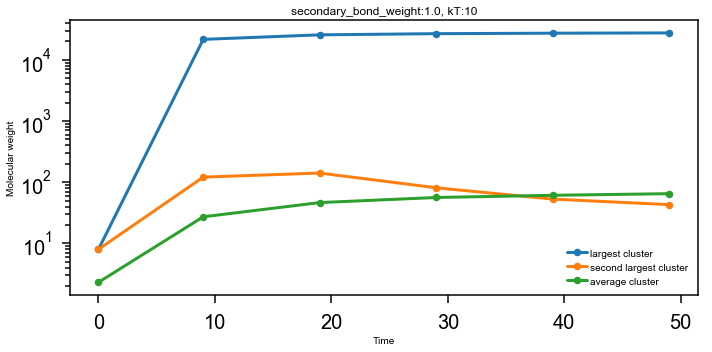

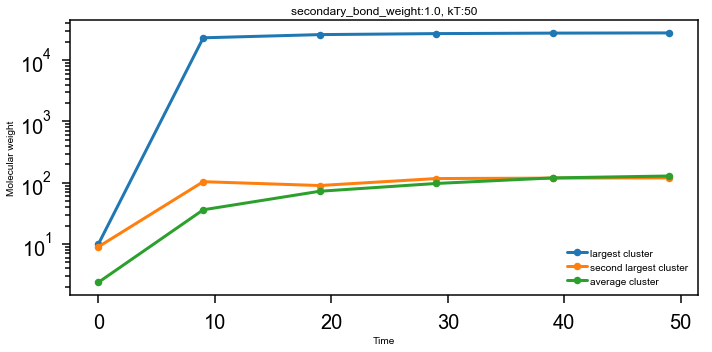

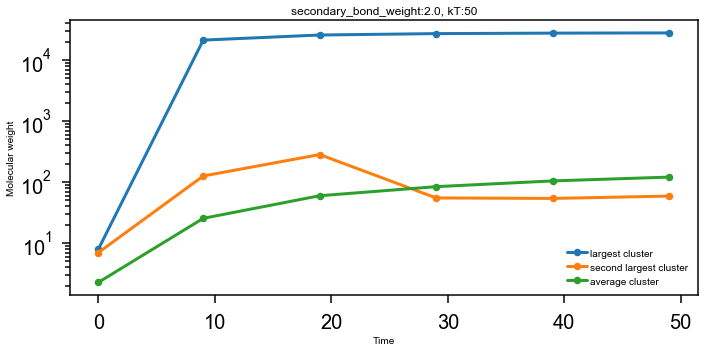

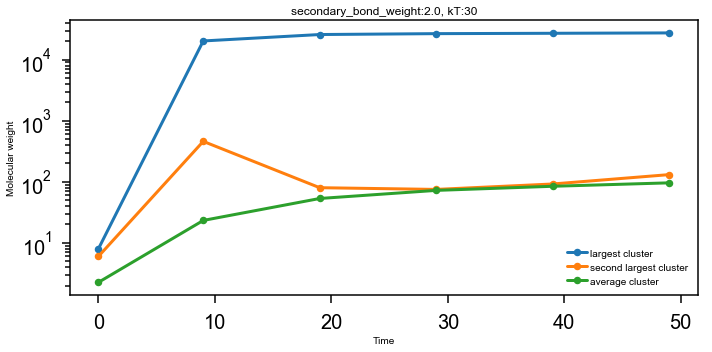

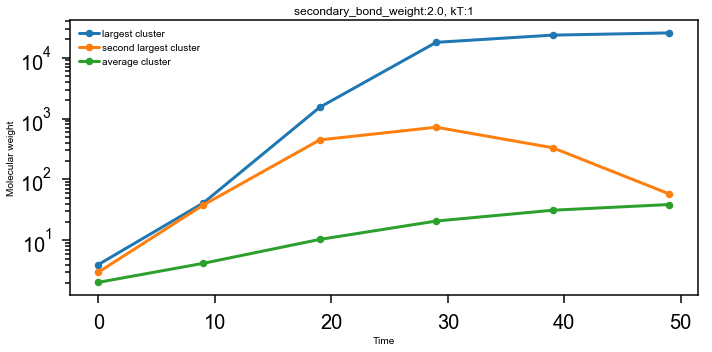

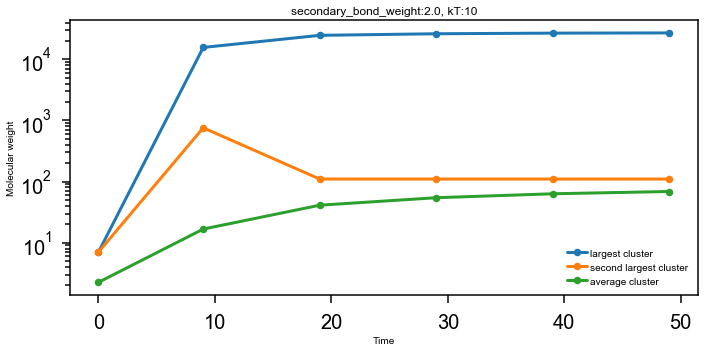

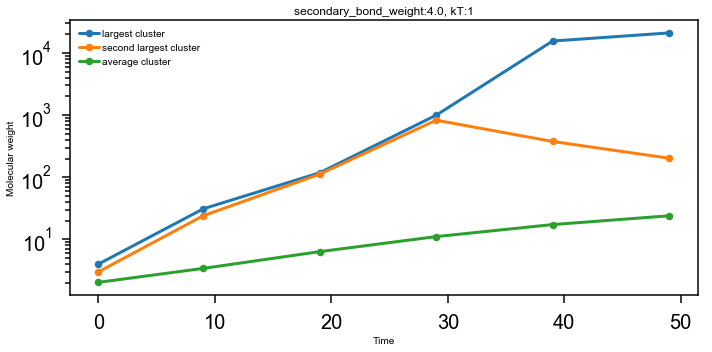

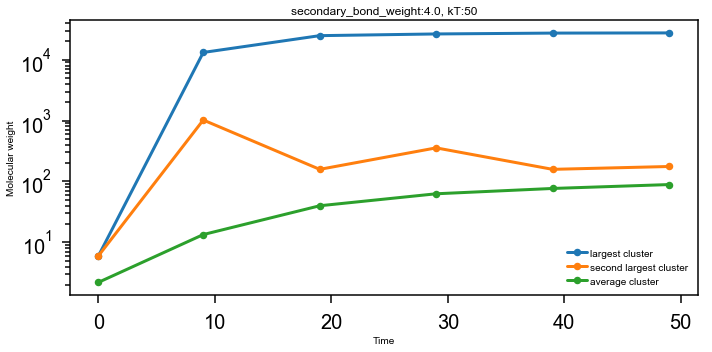

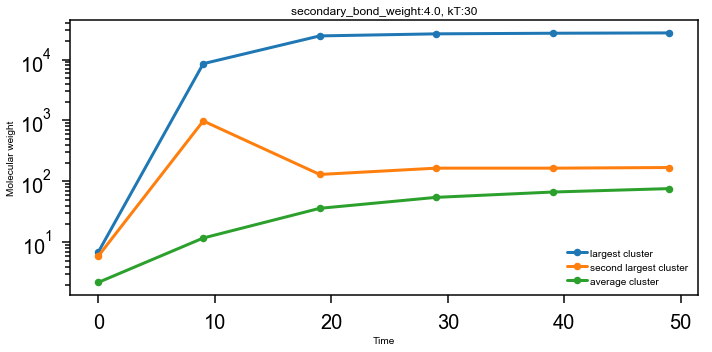

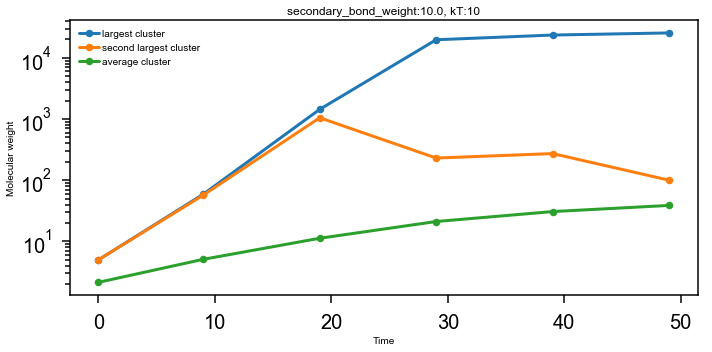

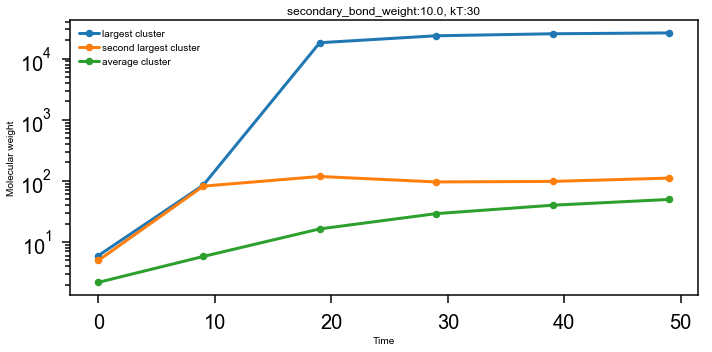

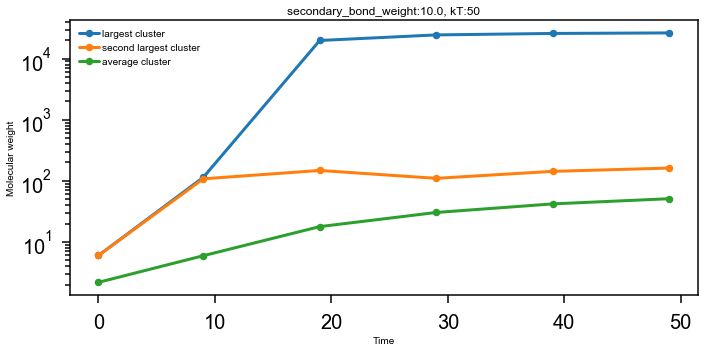

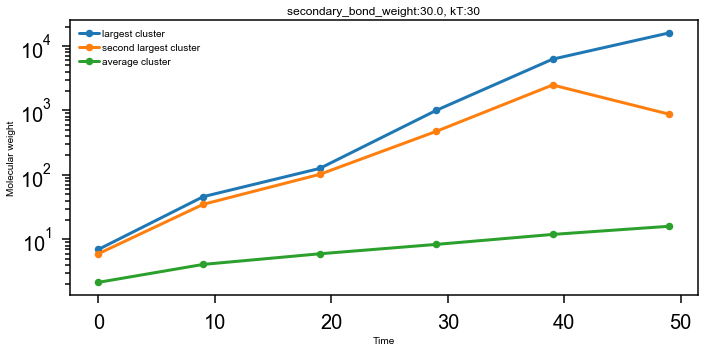

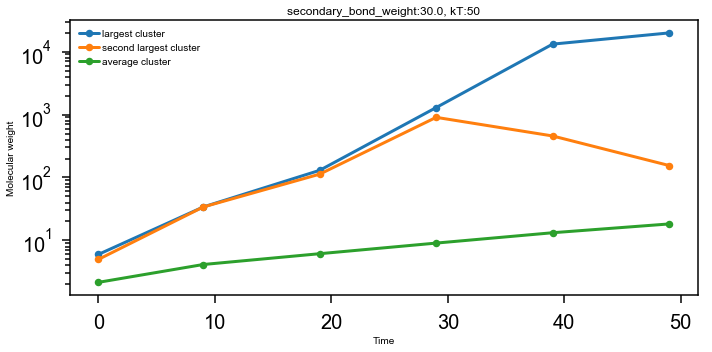

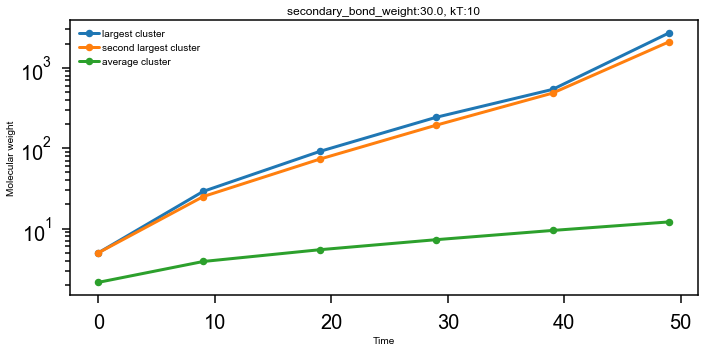

In [14]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
plt.figure(figsize=(15,10))

for sbw in sbws:
    

    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kTs=[]
            largest_networks = []
            second_largest_networks = []
            average_network_lens = []
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
                cluster_distributions.append(sorted_cc)
                largest_networks.append(sorted_cc[0])
                second_largest_networks.append(sorted_cc[1])
                average_network_lens.append(np.mean(sorted_cc))
                
            plt.figure(figsize=(10,5))
            plt.xlabel('Time')
            plt.ylabel('Molecular weight')
            plt.plot(time_steps, largest_networks,linestyle='-',marker='o',label='largest cluster')
            plt.plot(time_steps, second_largest_networks,linestyle='-',marker='o',label='second largest cluster')
            plt.plot(time_steps, average_network_lens,linestyle='-',marker='o',label='average cluster')
            plt.legend()
            #plt.xscale('log')
            plt.yscale('log')
            plt.title('secondary_bond_weight:{}, kT:{}'.format(sbw,kT))
            plt.savefig('cl_sz_sbw_{}_kT_{}.png'.format(sbw,kT))
            plt.show()

[1, 100, 1000, 10000, 100000]
[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 2 2 2 2 2] 2 1000
[3112  777  438  363  319  301] 1 100


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


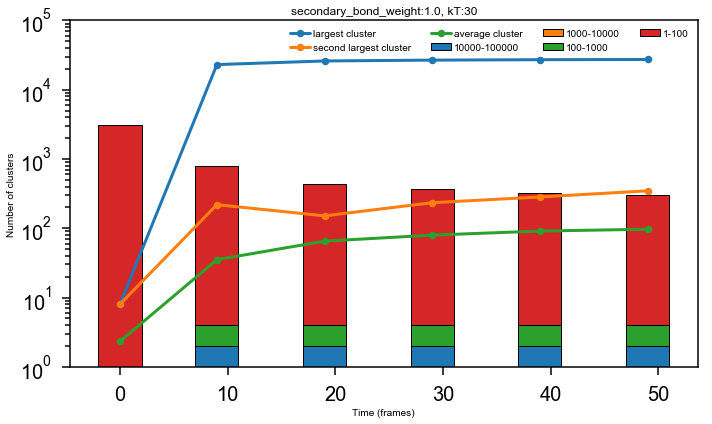

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 3 1 0 0] 2 1000
[ 702 3833 1526  961  752  663] 1 100


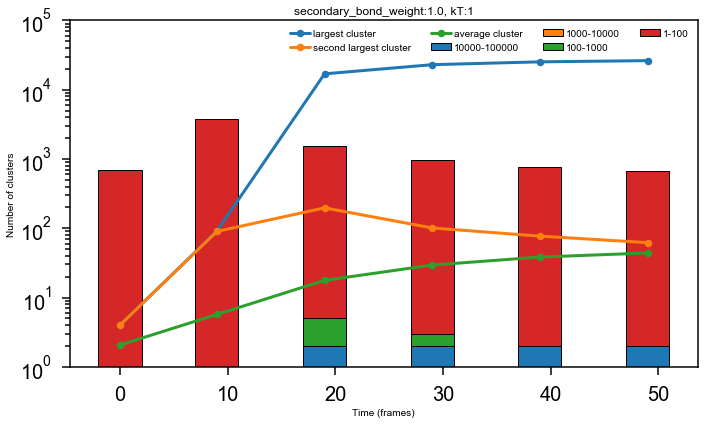

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 1 1 0 0 0] 2 1000
[2839 1001  620  520  482  455] 1 100


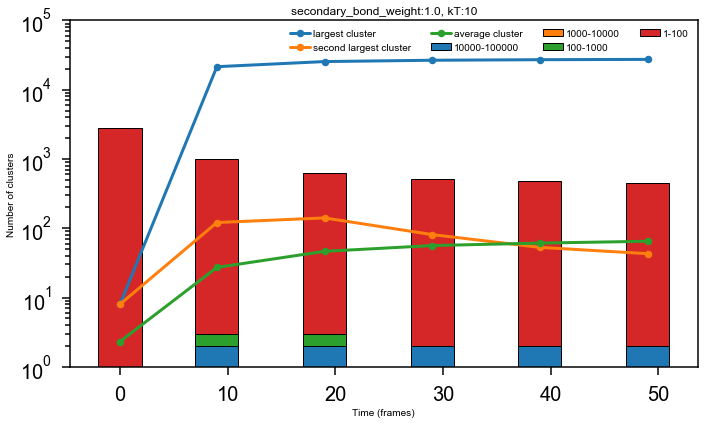

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 2 0 1 1 1] 2 1000
[3183  755  394  297  242  226] 1 100


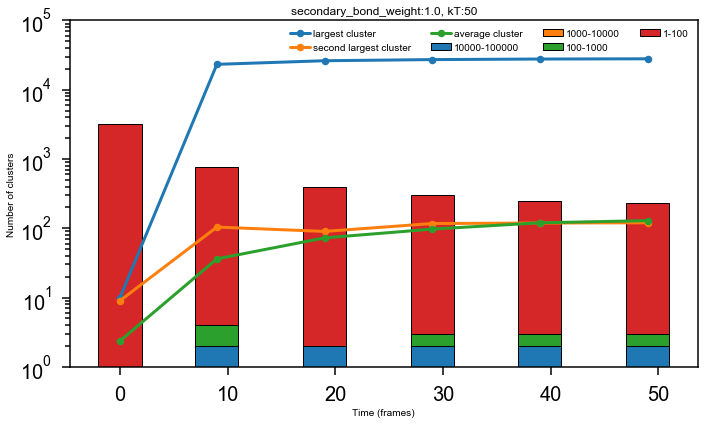

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 3 1 0 0 0] 2 1000
[3221 1081  481  346  280  243] 1 100


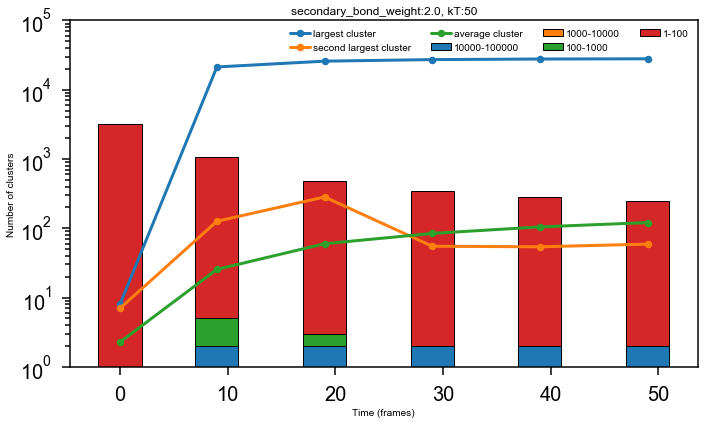

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 4 0 0 0 1] 2 1000
[3271 1181  541  403  347  305] 1 100


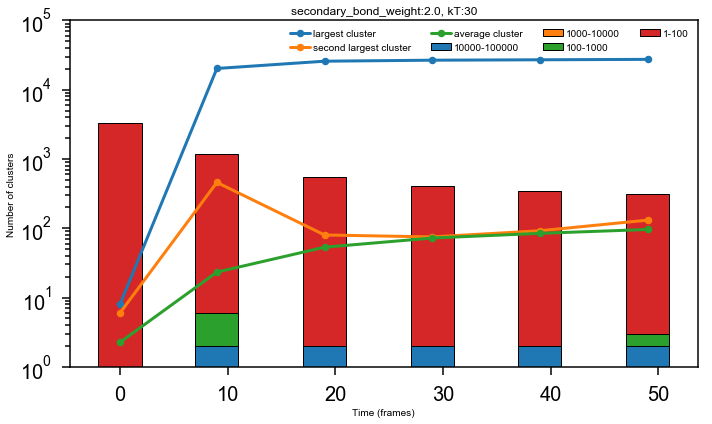

[0 0 0 1 1 1] 4 100000
[0 0 1 0 0 0] 3 10000
[ 0  0 25  5  1  0] 2 1000
[ 676 5053 2555 1356  923  753] 1 100


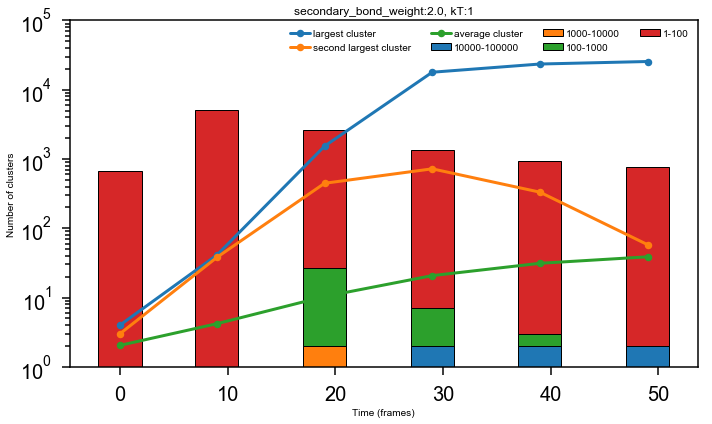

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 9 3 1 1 1] 2 1000
[2907 1631  703  538  466  429] 1 100


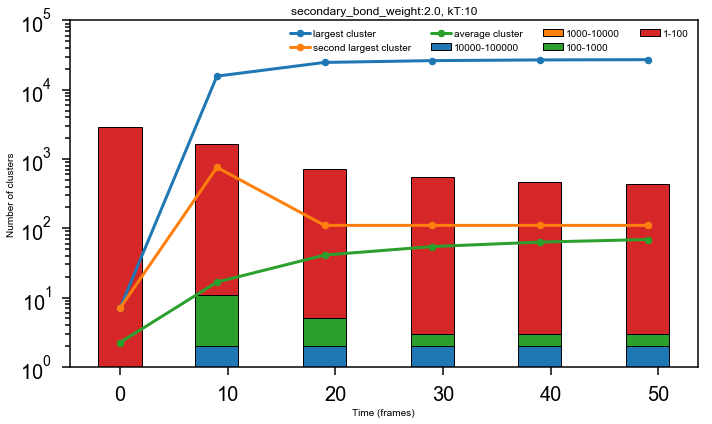

[0 0 0 0 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  0  2 31 10  3] 2 1000
[ 720 6081 4163 2521 1665 1221] 1 100


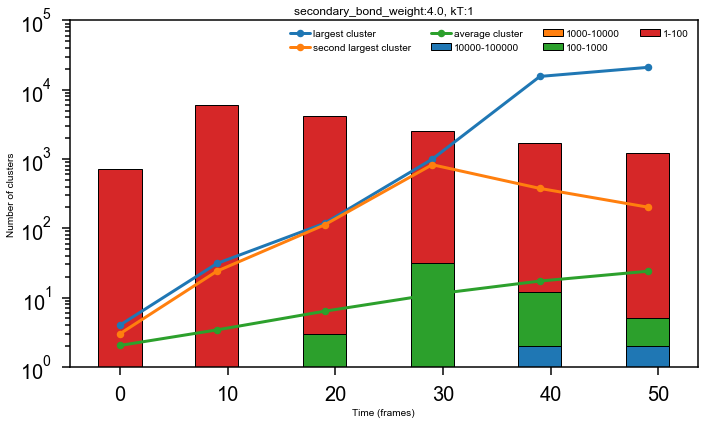

[0 1 1 1 1 1] 4 100000
[0 1 0 0 0 0] 3 10000
[0 7 1 2 1 1] 2 1000
[3320 2066  730  467  384  332] 1 100


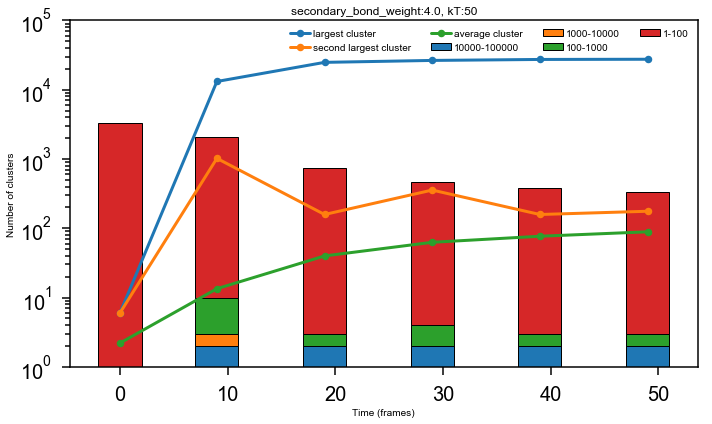

[0 0 1 1 1 1] 4 100000
[0 1 0 0 0 0] 3 10000
[0 9 1 1 1 1] 2 1000
[3241 2339  805  537  441  388] 1 100


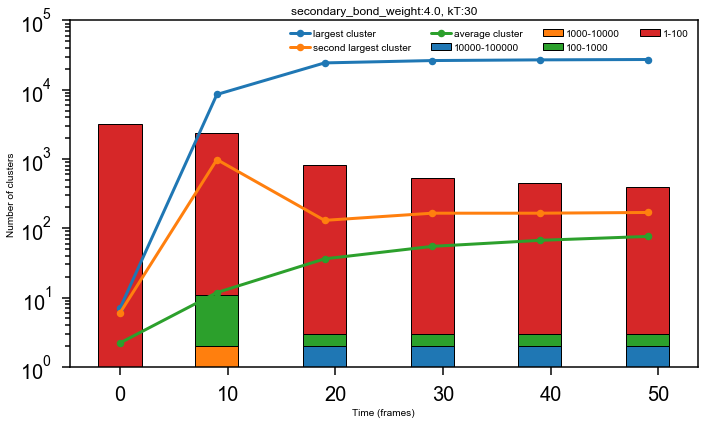

[0 0 0 1 1 1] 4 100000
[0 0 2 0 0 0] 3 10000
[ 0  0 29  4  2  1] 2 1000
[2995 5354 2583 1405  971  772] 1 100


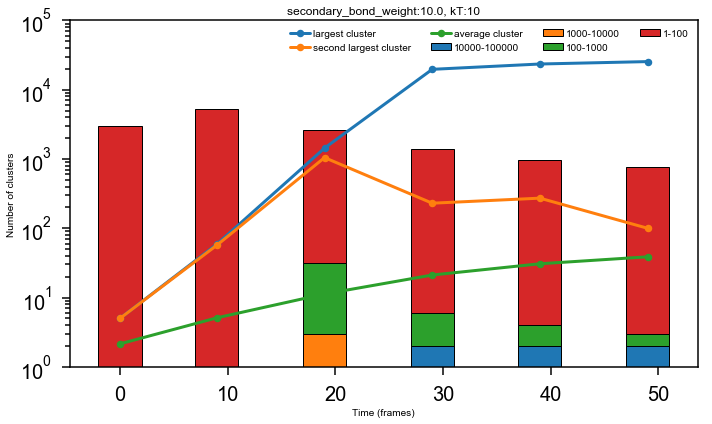

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 1 0 0 2] 2 1000
[3290 4775 1804 1024  748  600] 1 100


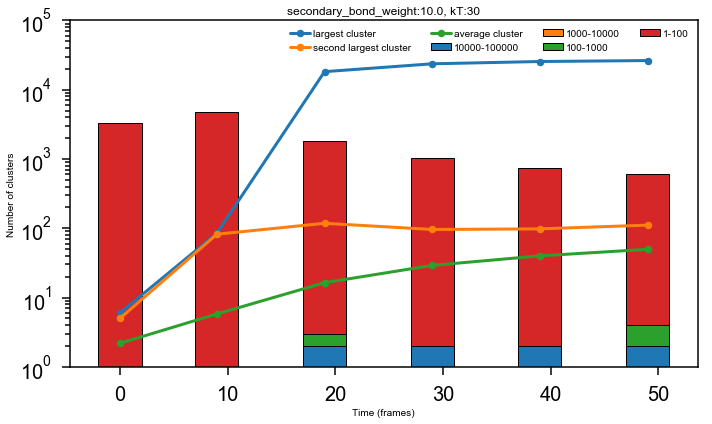

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 4 3 1 1 1] 2 1000
[3326 4668 1656  981  711  585] 1 100


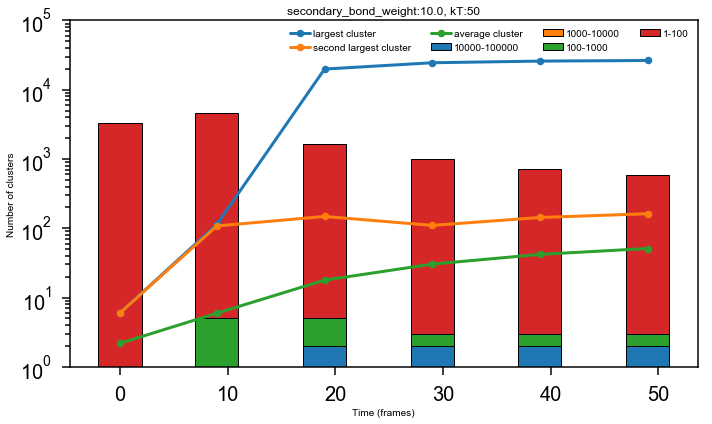

[0 0 0 0 0 1] 4 100000
[0 0 0 1 2 0] 3 10000
[ 0  0  2 27 16  6] 2 1000
[3363 6726 4951 3552 2494 1871] 1 100


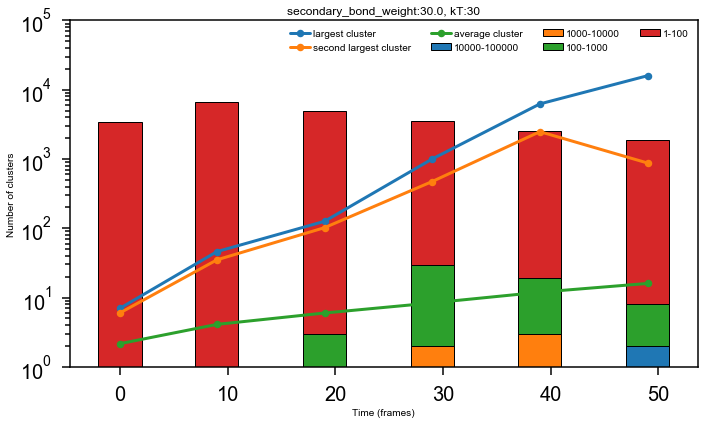

[0 0 0 0 1 1] 4 100000
[0 0 0 1 0 0] 3 10000
[ 0  0  4 19 11  4] 2 1000
[3360 6697 4823 3281 2251 1636] 1 100


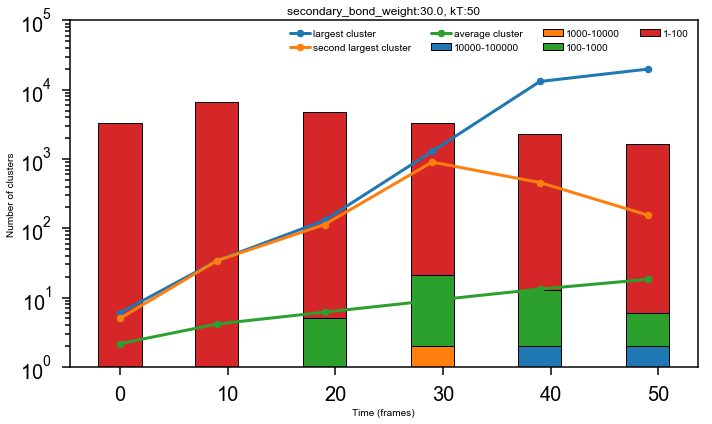

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 2] 3 10000
[ 0  0  0 14 30 30] 2 1000
[2980 6988 5426 4105 3137 2449] 1 100


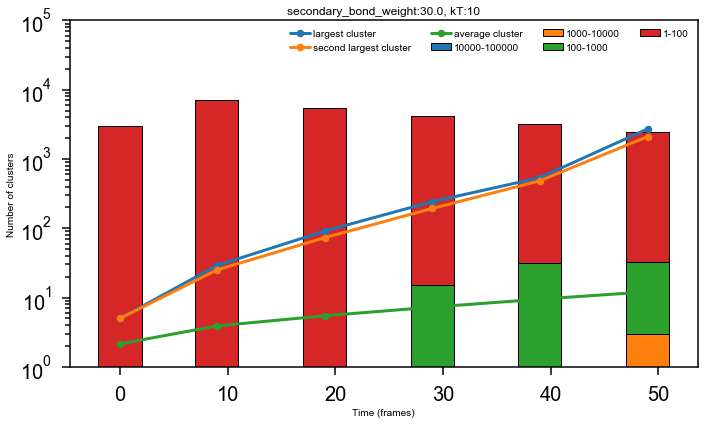

In [24]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('final.hoomdxml') and job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
plt.figure(figsize=(15,10))
#bins = [1,5,10,50,100,1000,10000,20000,25000,27500,30000]#np.logspace(0.2,4.5,num=15)
bins = [1,100,1000,10000,100000]
#bins = np.logspace(0.,4.5,num=15)
print(bins)
#bins = np.linspace(0,40000,num=15)
bin_mids = []

NUM_COLORS = 14

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
#plt.color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])


for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':# and job.sp.temp_prof[-1][1]==1:
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            largest_networks = []
            second_largest_networks = []
            average_network_lens = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=False)]
                hist,bin_edges = np.histogram(sorted_cc,bins=bins)
                cluster_distributions.append(hist)
                largest_networks.append(sorted_cc[-1])
                second_largest_networks.append(sorted_cc[-2])
                average_network_lens.append(np.mean(sorted_cc))
            
            distribs = np.array(cluster_distributions)
            fig = plt.figure(figsize=(10,6))
            width=4
            ax = fig.add_subplot(111)
            #ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
            bin_mids=[]
            for i,bin_edge in enumerate(bin_edges):
                if i>0:
                    bin_mids.append((bin_edge+bins[i-1])/2.)
            #print('bin_edges\n',bin_edges)
            #print('distribs\n',distribs)
            for i,bin_edge in reversed(list(enumerate(bin_edges))):
                #print(distribs[:,i],i)
                if i>0:
                    label = '{}-{}'.format(int(bin_edges[i-1]),int(bin_edges[i]))
                    #print('label is ',label)
                    dist = distribs[:,i-1]

                    print(dist,i,bin_edge)
                    if i == len(bin_edges)-1:
                        slice_sum = np.ones_like(dist)
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
                    else:
                        #if i == 1:
                        #    print(dist)
                        
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
            plt.plot(time_steps, largest_networks,linestyle='-',marker='o',label='largest cluster')
            plt.plot(time_steps, second_largest_networks,linestyle='-',marker='o',label='second largest cluster')
            plt.plot(time_steps, average_network_lens,linestyle='-',marker='o',label='average cluster')
                #print(slice_sum)
            plt.legend(ncol=4)
            plt.xlabel('Time (frames)')
            plt.ylabel('Number of clusters')
            
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,1.0,100000.0))
            #plt.xscale('log')
            plt.yscale('log')
            plt.title('secondary_bond_weight:{}, kT:{}'.format(sbw,kT))
            plt.savefig('sbw_{}_kT_{}.png'.format(sbw,kT))
            plt.show()

[1, 100, 1000, 10000, 100000]


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 2 2 2 2 2] 2 1000
[3112  777  438  363  319  301] 1 100


/Users/stephenthomas/miniconda3/envs/epoxpy_env/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


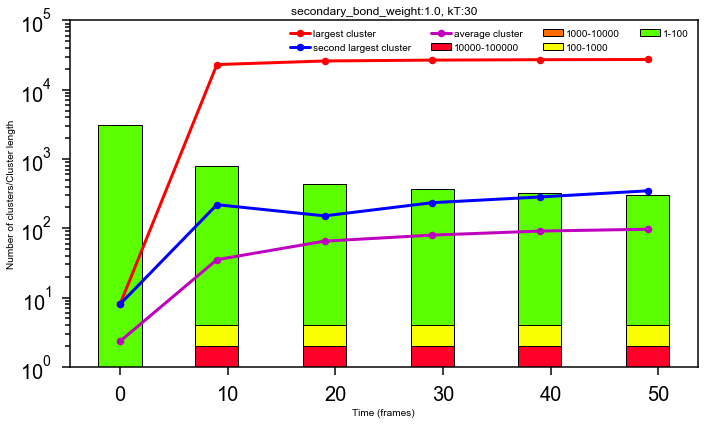

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 3 1 0 0] 2 1000
[ 702 3833 1526  961  752  663] 1 100


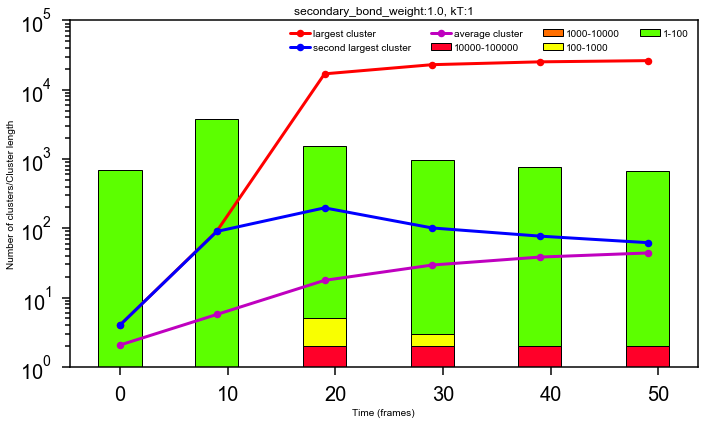

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 1 1 0 0 0] 2 1000
[2839 1001  620  520  482  455] 1 100


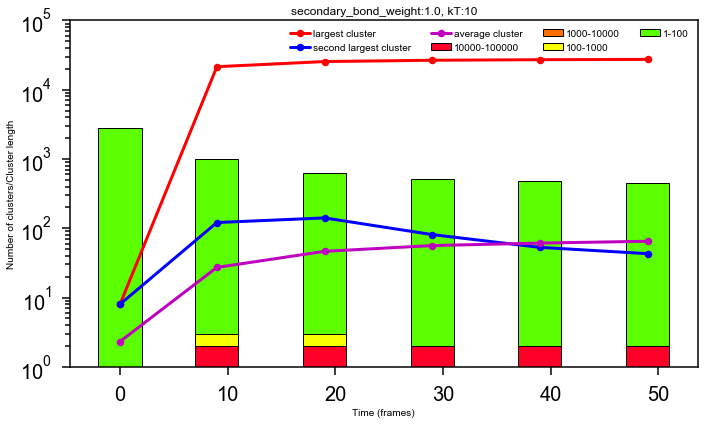

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 2 0 1 1 1] 2 1000
[3183  755  394  297  242  226] 1 100


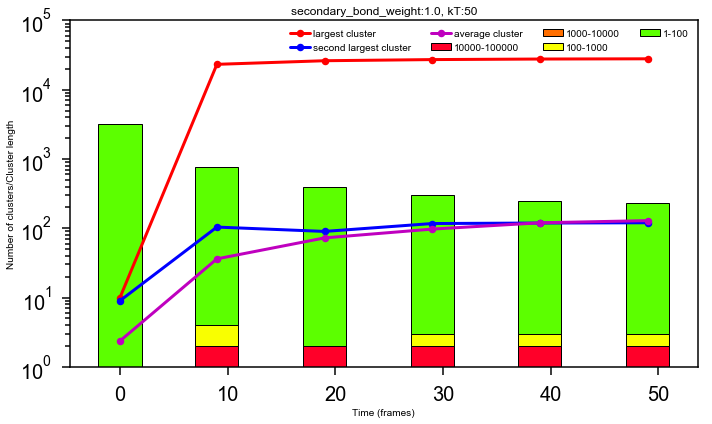

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 3 1 0 0 0] 2 1000
[3221 1081  481  346  280  243] 1 100


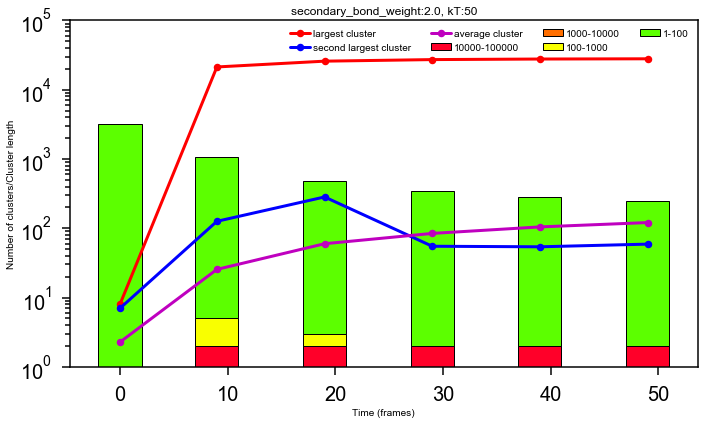

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 4 0 0 0 1] 2 1000
[3271 1181  541  403  347  305] 1 100


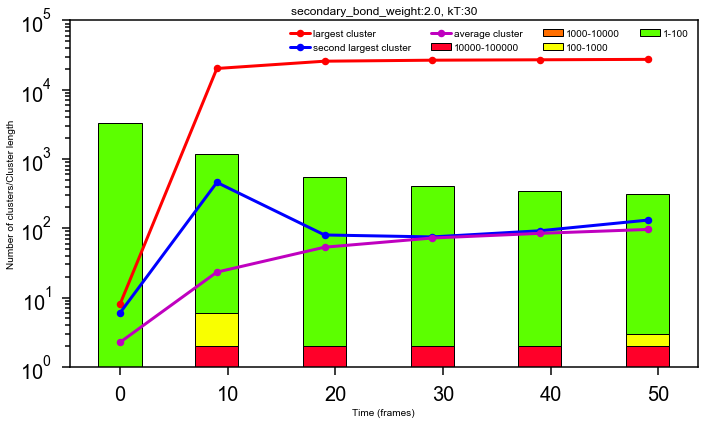

[0 0 0 1 1 1] 4 100000
[0 0 1 0 0 0] 3 10000
[ 0  0 25  5  1  0] 2 1000
[ 676 5053 2555 1356  923  753] 1 100


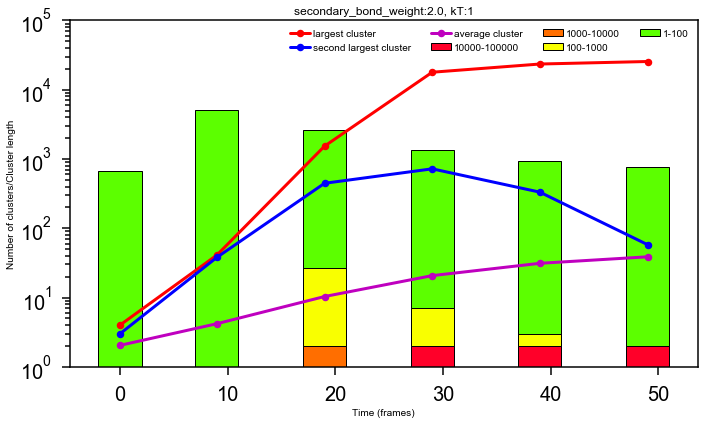

[0 1 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 9 3 1 1 1] 2 1000
[2907 1631  703  538  466  429] 1 100


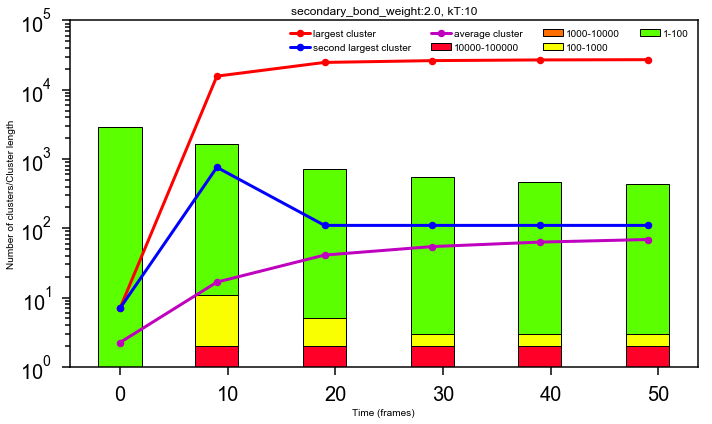

[0 0 0 0 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[ 0  0  2 31 10  3] 2 1000
[ 720 6081 4163 2521 1665 1221] 1 100


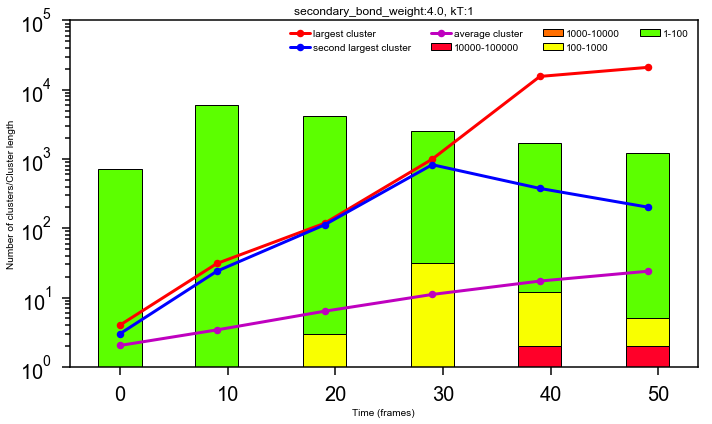

[0 1 1 1 1 1] 4 100000
[0 1 0 0 0 0] 3 10000
[0 7 1 2 1 1] 2 1000
[3320 2066  730  467  384  332] 1 100


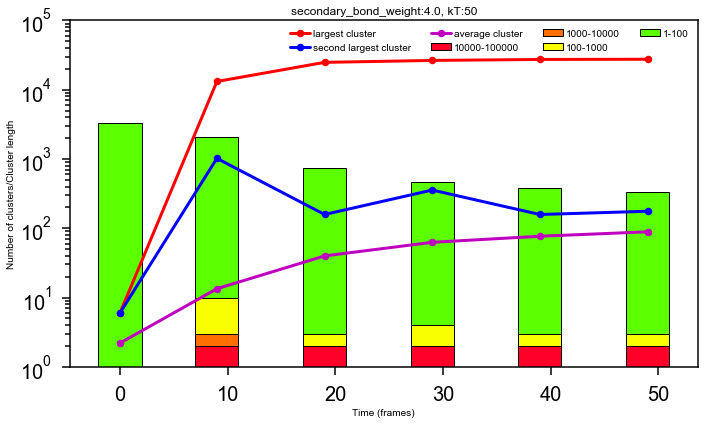

[0 0 1 1 1 1] 4 100000
[0 1 0 0 0 0] 3 10000
[0 9 1 1 1 1] 2 1000
[3241 2339  805  537  441  388] 1 100


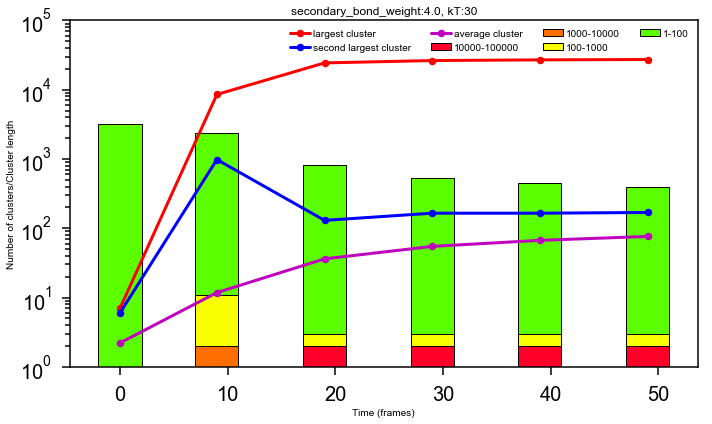

[0 0 0 1 1 1] 4 100000
[0 0 2 0 0 0] 3 10000
[ 0  0 29  4  2  1] 2 1000
[2995 5354 2583 1405  971  772] 1 100


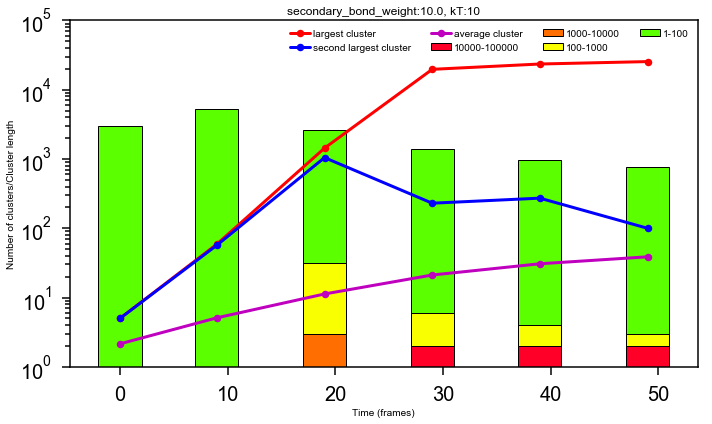

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 0 1 0 0 2] 2 1000
[3290 4775 1804 1024  748  600] 1 100


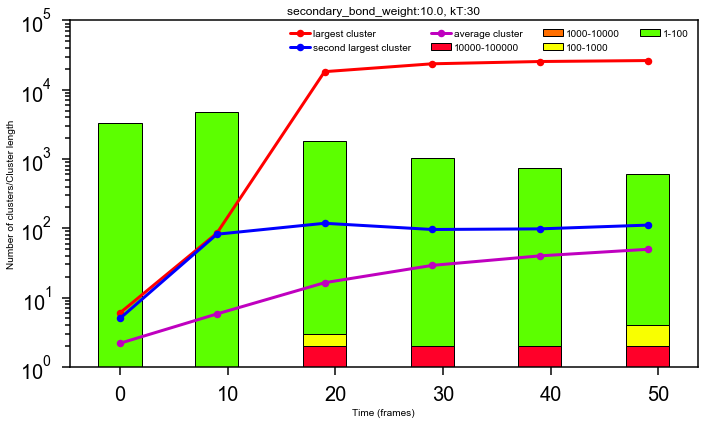

[0 0 1 1 1 1] 4 100000
[0 0 0 0 0 0] 3 10000
[0 4 3 1 1 1] 2 1000
[3326 4668 1656  981  711  585] 1 100


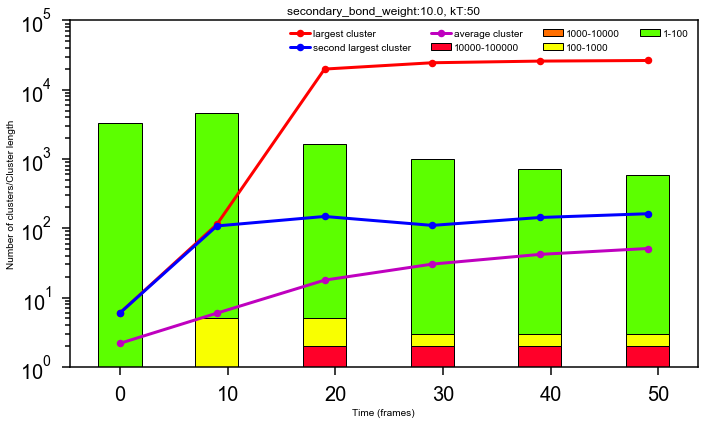

[0 0 0 0 0 1] 4 100000
[0 0 0 1 2 0] 3 10000
[ 0  0  2 27 16  6] 2 1000
[3363 6726 4951 3552 2494 1871] 1 100


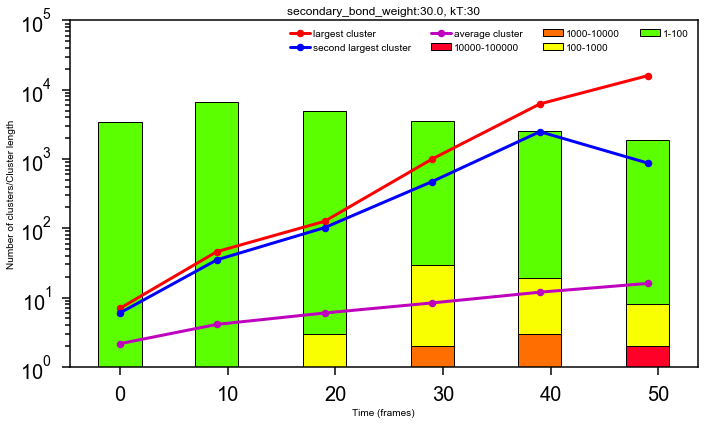

[0 0 0 0 1 1] 4 100000
[0 0 0 1 0 0] 3 10000
[ 0  0  4 19 11  4] 2 1000
[3360 6697 4823 3281 2251 1636] 1 100


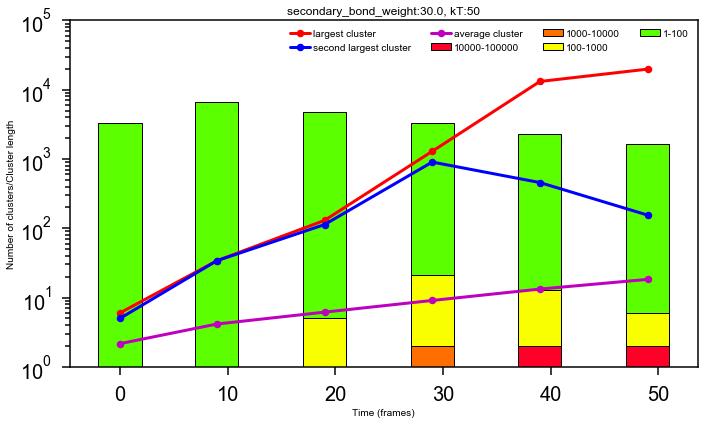

[0 0 0 0 0 0] 4 100000
[0 0 0 0 0 2] 3 10000
[ 0  0  0 14 30 30] 2 1000
[2980 6988 5426 4105 3137 2449] 1 100


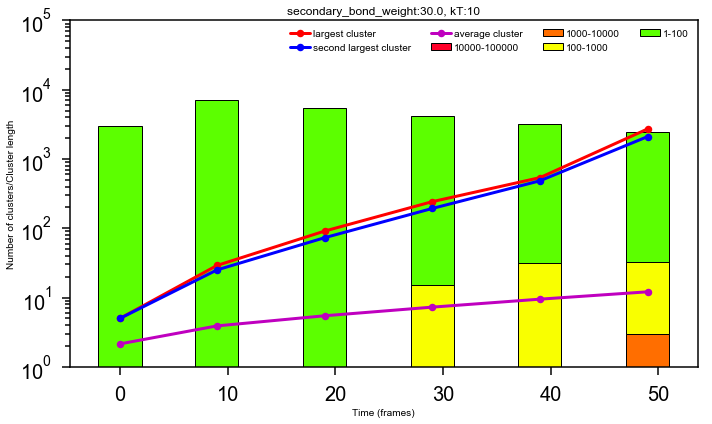

In [35]:
import signac
import gsd
import gsd.fl
import gsd.hoomd
import networkx as nx
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from freud import box, density
import matplotlib.pyplot as plt
%matplotlib inline

def get_status(job):
    status = 'init'
    if job.isfile('data.gsd'):
        status = 'job-computed'
    elif job.isfile('temperature_profile.png'):
        status = 'temperature-profile-created'

    return status

project = signac.init_project('ABCTypeEpoxy', data_path)

def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]

sbws = [1.0, 2.0, 4.0, 10.0, 30.0]
plt.figure(figsize=(15,10))
#bins = [1,5,10,50,100,1000,10000,20000,25000,27500,30000]#np.logspace(0.2,4.5,num=15)
bins = [1,100,1000,10000,100000]
#bins = np.logspace(0.,4.5,num=15)
print(bins)
#bins = np.linspace(0,40000,num=15)
bin_mids = []

NUM_COLORS = 10

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
#plt.color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])


for sbw in sbws:
    kTs=[]
    largest_networks = []
    second_largest_networks = []
    average_network_lens = []

    jobs = project.find_jobs({'activation_energy':1.0, 'sec_bond_weight':sbw})
    for job in jobs:
        #print(job)
        job_status = get_status(job)
        #print(job_status)
        if job_status == 'job-computed' and job.get_id() !='6378fac29834215b7ae2ef2f9190e2ae':# and job.sp.temp_prof[-1][1]==1:
            #print('final state points: {} time step, {} kT, status:{}'.format(job.sp.temp_prof[-1][0],job.sp.temp_prof[-1][1],job_status))
            #print(job)
            kT = job.sp.temp_prof[-1][1]
            kTs.append(kT)
            f = gsd.fl.GSDFile(job.fn('data.gsd'), 'rb')
            t = gsd.hoomd.HOOMDTrajectory(f)
            n_frames = len(t)
            #print('total frames ',n_frames)
            connected_components = []
            last_frame = n_frames-1
            time_steps = np.linspace(0,last_frame,6,endpoint=True,dtype=int)
            cluster_distributions = []
            largest_networks = []
            second_largest_networks = []
            average_network_lens = []
            for ts in time_steps:
                #print((ts))
                snapshot = t[int(ts)]
                sim_box = snapshot.configuration.box
                fbox = box.Box(Lx=sim_box[0], Ly=sim_box[1], Lz=sim_box[2])
                bonds = snapshot.bonds.group
                G = nx.MultiGraph(ts='time_step:{}, kT:{}'.format(last_frame,job.sp.temp_prof[-1][1]))
                bond_types = [snapshot.bonds.types[i] for i in snapshot.bonds.typeid]
                ab_indices = find_indices(bond_types, lambda e: e == 'A-B')
                ab_bonds = [bonds[i] for i in ab_indices]
                for bond in ab_bonds:
                    G.add_edge(bond[0],bond[1])
                sorted_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=False)]
                hist,bin_edges = np.histogram(sorted_cc,bins=bins)
                cluster_distributions.append(hist)
                largest_networks.append(sorted_cc[-1])
                second_largest_networks.append(sorted_cc[-2])
                average_network_lens.append(np.mean(sorted_cc))
            
            distribs = np.array(cluster_distributions)
            fig = plt.figure(figsize=(10,6))
            width=4
            ax = fig.add_subplot(111)
            ax.set_color_cycle([scalarMap.to_rgba(i) for i in range(NUM_COLORS)])
            bin_mids=[]
            for i,bin_edge in enumerate(bin_edges):
                if i>0:
                    bin_mids.append((bin_edge+bins[i-1])/2.)
            #print('bin_edges\n',bin_edges)
            #print('distribs\n',distribs)
            for i,bin_edge in reversed(list(enumerate(bin_edges))):
                #print(distribs[:,i],i)
                if i>0:
                    label = '{}-{}'.format(int(bin_edges[i-1]),int(bin_edges[i]))
                    #print('label is ',label)
                    dist = distribs[:,i-1]

                    print(dist,i,bin_edge)
                    if i == len(bin_edges)-1:
                        slice_sum = np.ones_like(dist)
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
                    else:
                        #if i == 1:
                        #    print(dist)
                        
                        plt.bar(time_steps, dist, bottom=slice_sum, edgecolor='black',width=width,label=label)
                        slice_sum += dist
            plt.plot(time_steps, largest_networks,color='r',linestyle='-',marker='o',label='largest cluster')
            plt.plot(time_steps, second_largest_networks,color='b',linestyle='-',marker='o',label='second largest cluster')
            plt.plot(time_steps, average_network_lens,color='m',linestyle='-',marker='o',label='average cluster')
                #print(slice_sum)
            plt.legend(ncol=4)
            plt.xlabel('Time (frames)')
            plt.ylabel('Number of clusters/Cluster length')
            
            x1,x2,y1,y2 = plt.axis()
            plt.axis((x1,x2,1.0,100000.0))
            #plt.xscale('log')
            plt.yscale('log')
            plt.title('secondary_bond_weight:{}, kT:{}'.format(sbw,kT))
            plt.savefig('sbw_{}_kT_{}.png'.format(sbw,kT))
            plt.show()